In [1]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from preprocess import (
    load_all_cases, create_tabular_dataset, create_beat_labels,
    create_rhythm_labels, create_sequence_dataset, preprocess_for_ml,
    BEAT_LABELS, RHYTHM_LABELS
)

# In notebook Cell 1, change:
from train_models_simple import (
    create_ml_models, train_traditional_ml,
    evaluate_models_on_test
)

from evaluate_models import (
    evaluate_multi_class, plot_confusion_matrix, plot_per_class_metrics,
    plot_roc_curves_multiclass, plot_learning_curves, create_metrics_comparison_table
)

from models import LightweightLSTM
# import torch

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print("🚀 Ready to run arrhythmia classification experiments")


✅ Libraries imported successfully!
🚀 Ready to run arrhythmia classification experiments


In [2]:
# Load all cases
print("📂 Loading data...")
annotations_dict, metadata_df = load_all_cases()

print(f"\n✅ Dataset loaded:")
print(f"   Total patients: {len(annotations_dict)}")
print(f"   Total beats: {metadata_df['total_beats'].sum():,}")
print(f"   Total duration: {metadata_df['analyzed_duration_sec'].sum()/3600:.1f} hours")


📂 Loading data...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 6 samples from 'rhythm_label' (excluded classes: ['Unclassifiable',

In [3]:
metadata_df

,case_id,analysis_start_time_sec,analysis_end_time_sec,analyzed_duration_sec,total_beats,rhythm_classes
0,1001,4993.494444,6188.511111,1195.016667,1047,"N, SR-mPVC-BT"
1,1002,6153.197222,7352.455556,1199.258333,1466,"N, Noise, SVTA"
2,1018,1523.447222,2541.350000,1017.902778,1087,"N, SVTA, VT"
3,1023,3001.583333,4304.436111,1302.852778,1341,"AFIB/AFL, Noise"
4,103,275.705556,1469.844444,1194.138889,1234,"N, Noise, SR-mPAC-BT, VT"
...,...,...,...,...,...,...
477,964,6153.819444,7351.241667,1197.422222,1241,"MAT, N, SND"
478,965,9.186111,1042.572222,1033.386111,879,"AFIB/AFL, N, SVTA"
479,98,153.150000,1288.486111,1135.336111,1568,"N, Noise, SR-mPVC-BT"
480,984,5532.227778,6243.236111,711.008333,1681,"AFIB/AFL, SVTA, VT"


## Section 1: Data Preparation for Deep Learning

Extract features and create sequence data for DL models.


In [4]:
# Create tabular features and labels
print("📊 Extracting features...")
features_df = create_tabular_dataset(annotations_dict, metadata_df)
beat_labels_df = create_beat_labels(annotations_dict)
rhythm_labels_df = create_rhythm_labels(annotations_dict, metadata_df)

print(f"\n✅ Features extracted:")
print(f"   Features: {features_df.shape}")
print(f"   Beat labels: {beat_labels_df.shape}")
print(f"   Rhythm labels: {rhythm_labels_df.shape}")


📊 Extracting features...
Extracting features from 482 patients...
✅ Extracted 32 features for 482 patients

✅ Features extracted:
   Features: (482, 32)
   Beat labels: (482, 2)
   Rhythm labels: (482, 2)


In [5]:
rhythm_labels_df

,case_id,rhythm_label
0,1001,N
1,1002,N
2,1018,N
3,1023,AFIB/AFL
4,103,N
...,...,...
477,964,MAT
478,965,AFIB/AFL
479,98,N
480,984,AFIB/AFL


In [6]:
# Create sequence data for deep learning
print("📐 Creating sequence data...")

def create_rhythm_sequence_data(annotations_dict, metadata_df, window_size=60, stride=30):
    from preprocess import create_sequence_dataset
    sequences, labels, patient_ids = create_sequence_dataset(
        annotations_dict, metadata_df, window_size=window_size, stride=stride
    )
    print(f'✅ Created {len(sequences)} windows from {len(set(patient_ids))} patients')
    print(f'   Sequence shape: {sequences.shape}')
    print(f'   Classes: {sorted(set(labels))}')
    return sequences, labels, patient_ids

# Generate sequence dataset using helper
rhythm_sequences, rhythm_seq_labels, rhythm_patient_ids = create_rhythm_sequence_data(
    annotations_dict, metadata_df, window_size=60, stride=30
)


print(f"\n✅ Sequence data created:")
print(f"   Sequences: {len(rhythm_sequences)}")
print(f"   Sequence length: {rhythm_sequences[0].shape}")
print(f"   Classes in sequences: {sorted(set(rhythm_seq_labels))}")
print(f"   Class distribution:", pd.Series(rhythm_seq_labels).value_counts().to_dict())


📐 Creating sequence data...
Creating sequence windows (size=60, stride=30)...
✅ Created 21603 windows from 482 patients
✅ Created 21603 windows from 482 patients
   Sequence shape: (21603, 60)
   Classes: [np.str_('AFIB/AFL'), np.str_('AVB'), np.str_('MAT'), np.str_('N'), np.str_('Noise'), np.str_('SND'), np.str_('SR-mPAC-BT'), np.str_('SR-mPVC-BT'), np.str_('SVTA')]

✅ Sequence data created:
   Sequences: 21603
   Sequence length: (60,)
   Classes in sequences: [np.str_('AFIB/AFL'), np.str_('AVB'), np.str_('MAT'), np.str_('N'), np.str_('Noise'), np.str_('SND'), np.str_('SR-mPAC-BT'), np.str_('SR-mPVC-BT'), np.str_('SVTA')]
   Class distribution: {'N': 13432, 'AFIB/AFL': 5340, 'SND': 743, 'SR-mPVC-BT': 710, 'SR-mPAC-BT': 577, 'MAT': 333, 'Noise': 166, 'SVTA': 158, 'AVB': 144}


In [7]:
rhythm_sequences.shape, rhythm_seq_labels.shape

((21603, 60), (21603,))

In [8]:
rhythm_seq_labels

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], shape=(21603,), dtype='<U10')

## Section 2: Split Data for Deep Learning

Split sequences into train/val/test sets with patient-level stratification.


In [9]:
# Convert sequences to numpy array
X_sequences = np.array(rhythm_sequences)
y_sequences = np.array(rhythm_seq_labels)

# Get unique classes and encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_sequences)

print(f"Sequence data shape: {X_sequences.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Classes: {label_encoder.classes_}")
print(f"Class distribution:", pd.Series(y_sequences).value_counts().to_dict())


Sequence data shape: (21603, 60)
Encoded labels shape: (21603,)
Classes: ['AFIB/AFL' 'AVB' 'MAT' 'N' 'Noise' 'SND' 'SR-mPAC-BT' 'SR-mPVC-BT' 'SVTA']
Class distribution: {'N': 13432, 'AFIB/AFL': 5340, 'SND': 743, 'SR-mPVC-BT': 710, 'SR-mPAC-BT': 577, 'MAT': 333, 'Noise': 166, 'SVTA': 158, 'AVB': 144}


In [10]:
# Split data (simple split for now, no patient-level info in sequences)
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_sequences, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✅ Data splits:")
print(f"   Train: {X_train.shape} ({len(y_train)} samples)")
print(f"   Val: {X_val.shape} ({len(y_val)} samples)")
print(f"   Test: {X_test.shape} ({len(y_test)} samples)")


✅ Data splits:
   Train: (12961, 60) (12961 samples)
   Val: (4321, 60) (4321 samples)
   Test: (4321, 60) (4321 samples)


In [11]:
# Calculate class weights for imbalanced dataset
import torch
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)
class_weights_array = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights = torch.tensor(class_weights_array, dtype=torch.float32)

print(f"Class weights: {dict(zip([label_encoder.classes_[i] for i in unique_classes], class_weights_array))}")


Class weights: {np.str_('AFIB/AFL'): np.float64(0.4494728811208212), np.str_('AVB'): np.float64(16.74547803617571), np.str_('MAT'): np.float64(7.200555555555556), np.str_('N'): np.float64(0.1786960058457763), np.str_('Noise'): np.float64(14.546576879910214), np.str_('SND'): np.float64(3.2289486796213254), np.str_('SR-mPAC-BT'): np.float64(4.1621708413615925), np.str_('SR-mPVC-BT'): np.float64(3.3805425143453314), np.str_('SVTA'): np.float64(15.15906432748538)}


## Section 3: Train LSTM Model


In [12]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = len(label_encoder.classes_)
model = LightweightLSTM(input_size=1, hidden_size=64, num_layers=2, num_classes=num_classes, dropout=0.2).to(device)

print(f"✅ Model created: {model.__class__.__name__}")
print(f"   Input size: 60")
print(f"   Output classes: {num_classes}")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
✅ Model created: LightweightLSTM
   Input size: 60
   Output classes: 9
   Model parameters: 51,017


In [13]:
# Create PyTorch dataloaders
batch_size = 32
num_epochs = 30
learning_rate = 0.001

# Convert to tensors and add channel dimension for LSTM
# Convert to tensors for LSTM (LSTM expects (batch, seq_len) or (batch, seq_len, features))
# The model will handle adding feature dimension internally
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("✅ Data loaders created")


✅ Data loaders created


In [14]:
# Training function
import torch.nn as nn
import torch

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, class_weights, device):
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print()
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

print("✅ Training function defined")


✅ Training function defined


In [15]:
# Train the model
print("🚀 Starting training...")
print(f"   Epochs: {num_epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Learning rate: {learning_rate}")
print(f"   Device: {device}")
print()

results = train_model(model, train_loader, val_loader, num_epochs, learning_rate, class_weights, device)

print(f"✅ Training complete!")
print(f"   Best validation accuracy: {results['best_val_acc']:.2f}%")


🚀 Starting training...
   Epochs: 30
   Batch size: 32
   Learning rate: 0.001
   Device: cuda

Epoch [5/30]
  Train Loss: 2.0223, Train Acc: 29.75%
  Val Loss: 2.0013, Val Acc: 25.43%

Epoch [10/30]
  Train Loss: 1.9035, Train Acc: 38.65%
  Val Loss: 1.8867, Val Acc: 43.81%

Epoch [15/30]
  Train Loss: 1.8075, Train Acc: 45.26%
  Val Loss: 1.7625, Val Acc: 39.71%

Epoch [20/30]
  Train Loss: 1.7351, Train Acc: 46.10%
  Val Loss: 1.7697, Val Acc: 41.08%

Epoch [25/30]
  Train Loss: 1.6346, Train Acc: 54.19%
  Val Loss: 1.8542, Val Acc: 17.66%

Epoch [30/30]
  Train Loss: 1.5507, Train Acc: 50.91%
  Val Loss: 1.6127, Val Acc: 60.24%

✅ Training complete!
   Best validation accuracy: 64.01%


## Section 4: Evaluate on Test Set


In [16]:
# Evaluate on test set
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
import torch

def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Decode labels
    predictions_str = label_encoder.inverse_transform(all_predictions)
    labels_str = label_encoder.inverse_transform(all_labels)
    
    return all_predictions, all_labels, predictions_str, labels_str, np.array(all_probabilities)

print("📊 Evaluating on test set...")
test_pred, test_true, test_pred_str, test_true_str, test_proba = evaluate_model(
    results['model'], test_loader, device, label_encoder
)

# Calculate basic metrics
accuracy = accuracy_score(test_true, test_pred)
print(f"\n✅ Test Results:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Calculate AUROC (Area Under ROC Curve) - Macro average
try:
    y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)
    if len(label_encoder.classes_) == 2:
        # Binary case
        auroc = roc_auc_score(test_true, test_proba[:, 1])
    else:
        # Multi-class: One-vs-Rest with macro average
        auroc = roc_auc_score(y_true_binary, test_proba, multi_class='ovr', average='macro')
    print(f"   AUROC (macro): {auroc:.4f}")
except Exception as e:
    print(f"   ⚠️  Could not calculate AUROC: {e}")
    auroc = np.nan

# Calculate AUPRC (Area Under Precision-Recall Curve) - Macro average
try:
    y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)
    if len(label_encoder.classes_) == 2:
        # Binary case
        auprc = average_precision_score(test_true, test_proba[:, 1])
    else:
        # Multi-class: Compute per-class, then macro average
        auprc_per_class = []
        for i in range(len(label_encoder.classes_)):
            ap = average_precision_score(y_true_binary[:, i], test_proba[:, i])
            auprc_per_class.append(ap)
        auprc = np.mean(auprc_per_class)  # Macro average
    print(f"   AUPRC (macro): {auprc:.4f}")
except Exception as e:
    print(f"   ⚠️  Could not calculate AUPRC: {e}")
    auprc = np.nan

print(f"\n{classification_report(test_true_str, test_pred_str)}")


📊 Evaluating on test set...

✅ Test Results:
   Accuracy: 0.6225 (62.25%)
   AUROC (macro): 0.8242
   AUPRC (macro): 0.3216

              precision    recall  f1-score   support

    AFIB/AFL       0.70      0.81      0.75      1068
         AVB       0.05      0.14      0.08        29
         MAT       0.02      0.01      0.02        67
           N       0.90      0.63      0.74      2686
       Noise       0.13      0.73      0.23        33
         SND       0.15      0.42      0.22       149
  SR-mPAC-BT       0.06      0.09      0.07       116
  SR-mPVC-BT       0.06      0.12      0.08       142
        SVTA       0.70      0.68      0.69        31

    accuracy                           0.62      4321
   macro avg       0.31      0.40      0.32      4321
weighted avg       0.75      0.62      0.67      4321



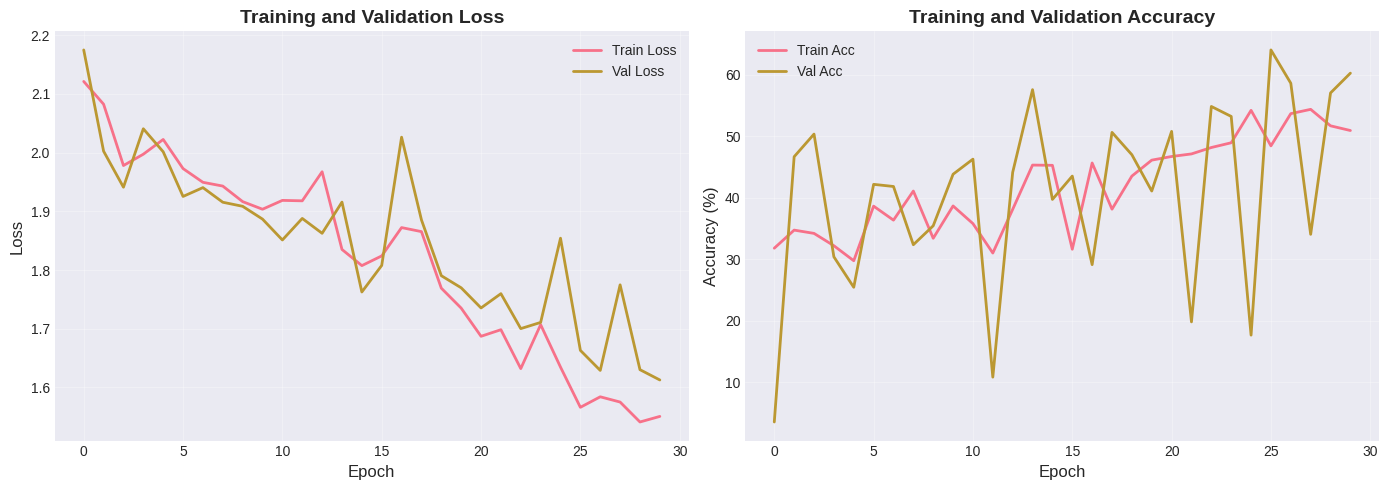

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(results['train_losses'], label='Train Loss', linewidth=2)
axes[0].plot(results['val_losses'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(results['train_accs'], label='Train Acc', linewidth=2)
axes[1].plot(results['val_accs'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


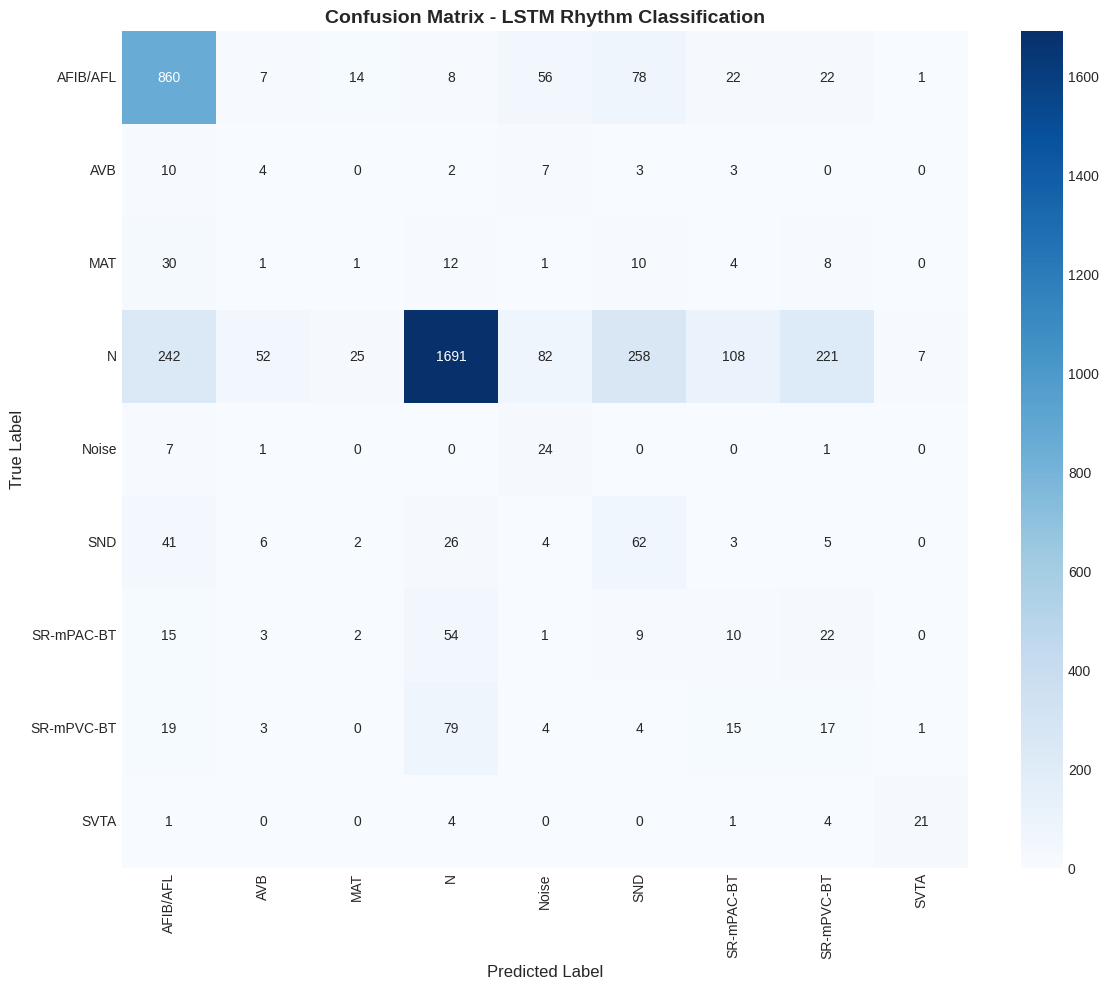


📊 Per-Class Metrics:
     Class  Precision   Recall  F1-Score    AUROC    AUPRC  Support
  AFIB/AFL   0.702041 0.805243  0.750109 0.939192 0.816394     1068
       AVB   0.051948 0.137931  0.075472 0.851054 0.047532       29
       MAT   0.022727 0.014925  0.018018 0.706320 0.030956       67
         N   0.901386 0.629561  0.741342 0.862421 0.897174     2686
     Noise   0.134078 0.727273  0.226415 0.943422 0.168221       33
       SND   0.146226 0.416107  0.216405 0.815501 0.137431      149
SR-mPAC-BT   0.060241 0.086207  0.070922 0.704473 0.064126      116
SR-mPVC-BT   0.056667 0.119718  0.076923 0.661642 0.053728      142
      SVTA   0.700000 0.677419  0.688525 0.933363 0.679067       31

📈 Overall Summary:
   Accuracy: 0.6225
   Macro AUROC: 0.8242
   Macro AUPRC: 0.3216


In [18]:
# Plot confusion matrix
cm = confusion_matrix(test_true_str, test_pred_str)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - LSTM Rhythm Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display per-class metrics including AUROC and AUPRC
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_true_str, test_pred_str, labels=label_encoder.classes_, zero_division=0
)

# Calculate per-class AUROC and AUPRC
y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)
auroc_per_class = []
auprc_per_class = []

for i, class_name in enumerate(label_encoder.classes_):
    try:
        # AUROC per class
        auroc_class = roc_auc_score(y_true_binary[:, i], test_proba[:, i])
        auroc_per_class.append(auroc_class)
    except Exception as e:
        auroc_per_class.append(np.nan)
    
    try:
        # AUPRC per class
        auprc_class = average_precision_score(y_true_binary[:, i], test_proba[:, i])
        auprc_per_class.append(auprc_class)
    except Exception as e:
        auprc_per_class.append(np.nan)

metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'AUROC': auroc_per_class,
    'AUPRC': auprc_per_class,
    'Support': support
})

print("\n📊 Per-Class Metrics:")
print(metrics_df.to_string(index=False))

print(f"\n📈 Overall Summary:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Macro AUROC: {auroc:.4f}")
print(f"   Macro AUPRC: {auprc:.4f}")


## Section 5: ROC and Precision-Recall Curves

Visualize ROC and Precision-Recall curves for each rhythm class.


## Section 6: Save Predictions for Visualization

Save predictions to a file that can be loaded in `classification_visualization.ipynb`.


In [19]:
# Save predictions for visualization notebook
import pickle
import os

# Create directory for saved predictions
# Notebooks are in arrdb/notebooks/, save to arrdb/experiments/results/predictions
current_dir = os.getcwd()
if current_dir.endswith('notebooks') or current_dir.endswith('notebooks/'):
    # We're in the notebooks directory, go up one level
    base_dir = os.path.dirname(current_dir)
    save_dir = os.path.join(base_dir, 'experiments', 'results', 'predictions')
elif 'arrdb' in current_dir:
    # We're in arrdb directory or a subdirectory
    # Find the arrdb base directory
    parts = current_dir.split(os.sep)
    if 'arrdb' in parts:
        arrdb_idx = parts.index('arrdb')
        base_dir = os.sep.join(parts[:arrdb_idx + 1])
        save_dir = os.path.join(base_dir, 'experiments', 'results', 'predictions')
    else:
        save_dir = os.path.join(current_dir, 'experiments', 'results', 'predictions')
else:
    # Try relative path from notebooks
    save_dir = os.path.abspath(os.path.join('..', 'experiments', 'results', 'predictions'))

os.makedirs(save_dir, exist_ok=True)
print(f"📁 Current directory: {current_dir}")
print(f"📁 Save directory: {save_dir}")
print(f"📁 Absolute path: {os.path.abspath(save_dir)}")

# Save rhythm classification predictions with test sequences
# Note: Make sure X_test and test_indices are defined from earlier cells
rhythm_predictions = {
    'test_pred_str': test_pred_str,
    'test_true_str': test_true_str,
    'test_proba': test_proba,
    'test_pred': test_pred,
    'test_true': test_true,
    'label_encoder': label_encoder,
    'task': 'rhythm',
    'num_classes': len(label_encoder.classes_),
    'class_names': list(label_encoder.classes_),
    'accuracy': accuracy,
    'auroc': auroc,
    'auprc': auprc
}

# Add test sequences if available
try:
    rhythm_predictions['test_sequences'] = X_test
    rhythm_predictions['test_indices'] = test_indices if 'test_indices' in locals() else None
    print("   ✓ Test sequences included")
except NameError:
    print("   ⚠️  X_test not found - sequences won't be saved")
    print("      Run cells 7-9 first to create test sequences")

save_path = os.path.join(save_dir, 'rhythm_classification_lstm_predictions.pkl')
try:
    with open(save_path, 'wb') as f:
        pickle.dump(rhythm_predictions, f)
    print(f"✅ Saved rhythm classification predictions to:")
    print(f"   {save_path}")
    print(f"   Absolute path: {os.path.abspath(save_path)}")
except Exception as e:
    print(f"❌ Error saving predictions: {e}")
    print(f"   Attempted path: {save_path}")
    print(f"   Current working directory: {os.getcwd()}")
    raise
print(f"\n📊 Saved data includes:")
print(f"   - test_pred_str: {len(test_pred_str)} predictions")
print(f"   - test_true_str: {len(test_true_str)} true labels")
print(f"   - test_proba: {test_proba.shape} probability matrix")
print(f"   - label_encoder: {len(label_encoder.classes_)} classes")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - AUROC: {auroc:.4f}")
print(f"   - AUPRC: {auprc:.4f}")


📁 Current directory: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks
📁 Save directory: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions
📁 Absolute path: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions
   ✓ Test sequences included
✅ Saved rhythm classification predictions to:
   /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/rhythm_classification_lstm_predictions.pkl
   Absolute path: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/experiments/results/predictions/rhythm_classification_lstm_predictions.pkl

📊 Saved data includes:
   - test_pred_str: 4321 predictions
   - test_true_str: 4321 true labels
   - test_proba: (4321, 9) probability matrix
   - label_encoder: 9 classes
   - Accuracy: 0.6225
   - AUROC: 0.8242
   - AUPRC: 0.3216


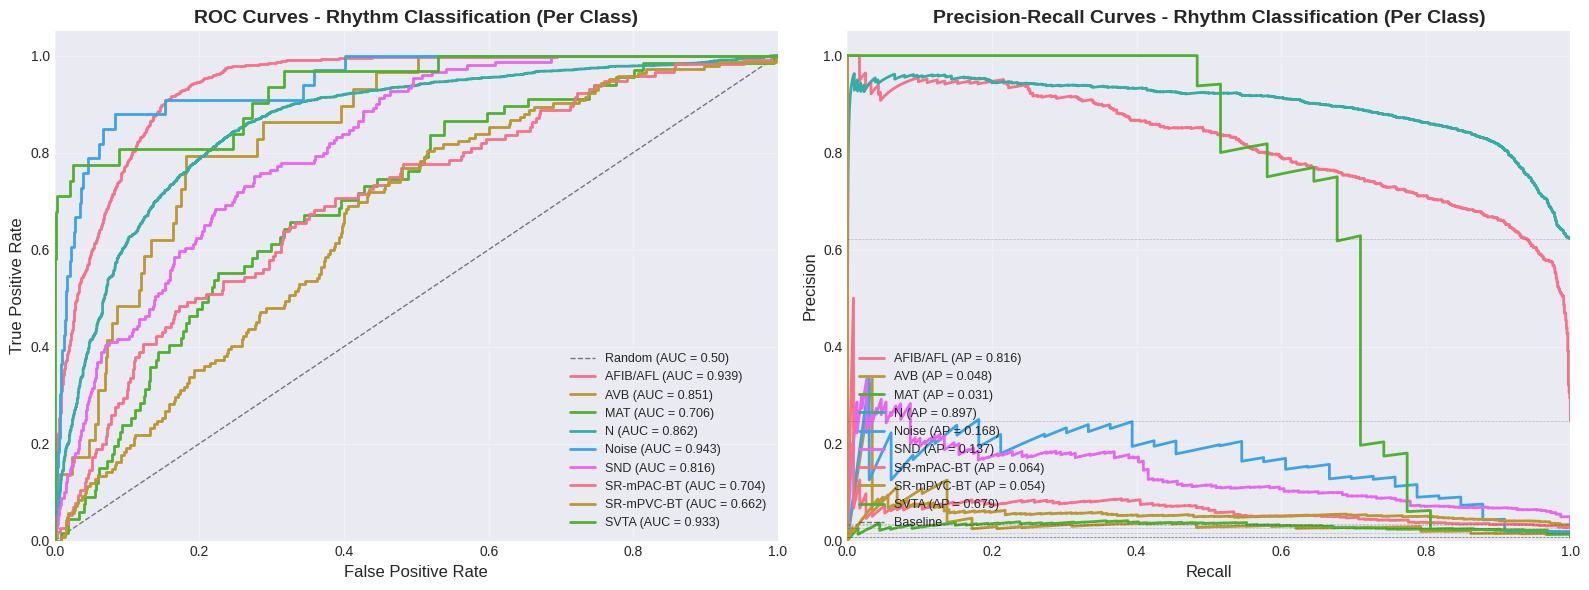


📊 Summary:
   Overall Macro AUROC: 0.8242
   Overall Macro AUPRC: 0.3216


In [20]:
# Plot ROC curves for each class
from sklearn.metrics import roc_curve, precision_recall_curve

y_true_binary = label_binarize(test_true_str, classes=label_encoder.classes_)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)', linewidth=1, alpha=0.5)
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], test_proba[:, i])
    roc_auc = auroc_per_class[i]
    if not np.isnan(roc_auc):
        axes[0].plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})', linewidth=2)

axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves - Rhythm Classification (Per Class)', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

# Precision-Recall Curves
for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_true_binary[:, i], test_proba[:, i])
    auprc_class = auprc_per_class[i]
    if not np.isnan(auprc_class):
        axes[1].plot(recall, precision, label=f'{class_name} (AP = {auprc_class:.3f})', linewidth=2)

# Baseline (random classifier)
baseline = np.sum(y_true_binary, axis=0) / len(y_true_binary)
for i, class_name in enumerate(label_encoder.classes_):
    axes[1].axhline(y=baseline[i], color='k', linestyle='--', alpha=0.2, linewidth=0.5)
axes[1].plot([], [], 'k--', label='Baseline', linewidth=1, alpha=0.5)

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves - Rhythm Classification (Per Class)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=9)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"   Overall Macro AUROC: {auroc:.4f}")
print(f"   Overall Macro AUPRC: {auprc:.4f}")
